In [1]:
import torch
import math
import matplotlib.pyplot as plt
from torchaudio.transforms import Spectrogram as Spectrogram
import librosa
import numpy as np
%matplotlib inline

In [2]:
# Signal
N = 50_000
num_harmoniques = 3
fs = 1
T = torch.arange(0, N)/fs
f =  torch.linspace(0.01, 0.15, N)
x = 0
for i in range(num_harmoniques):   
    x += torch.randn(1)*torch.sin(2*(i+1)*math.pi*torch.cumsum(f, dim=0)/fs) 
y = x + torch.randn(N)

Text(0.5, 0, 'Time')

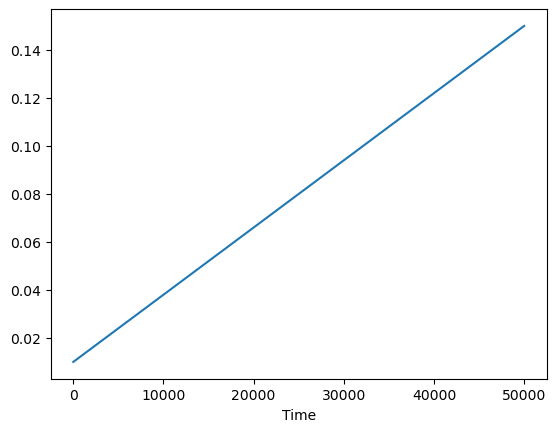

In [3]:
plt.plot(T, f)
plt.xlabel("Time")

Text(0.5, 0, 'Time')

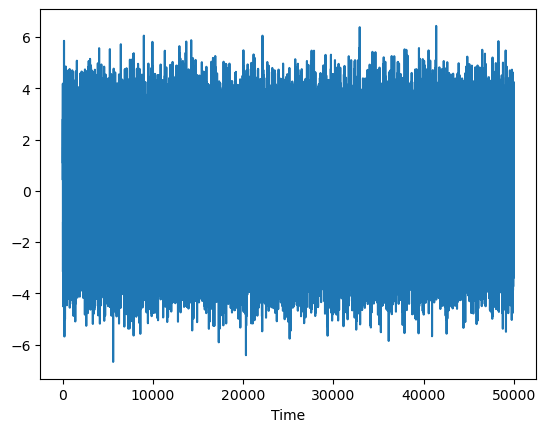

In [4]:
plt.plot(T, y);
plt.xlabel("Time")

In [5]:
def plot_spectrogram(spec, title=None, ylabel="frequency", db=True, xmax=None):
    fig, axs = plt.subplots(1, 1)
    #axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    #im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    times = np.linspace(0, spec.shape[1], spec.shape[1])
    freqs = np.linspace(0, 0.5, spec.shape[0])
    if db: 
        spec_ = librosa.power_to_db(spec)
    else: 
        spec_ = spec
    im = axs.pcolormesh(times, freqs, spec_)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

torch.Size([501, 491])


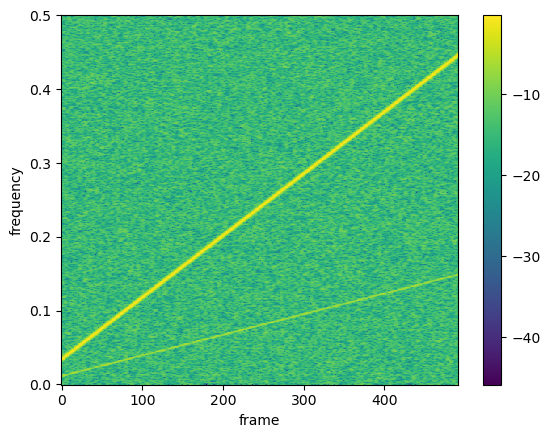

In [6]:
from dstft import FDSTFT
transform = FDSTFT(y[None, ...], win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec = transform(y[None, ...])[0][0]
print(spec.shape)
plot_spectrogram(spec, db=True)

In [7]:
# Spectrograms properties
L = spec.shape[0]
T = spec.shape[1]
df = fs/2/L
dt = y.shape[0]/(fs*T)

In [8]:
fmin = 0
fmax = 0.2
spec_db = torch.log(spec)
spec_db = spec_db-spec_db.min()

freqs = torch.linspace(0, 0.5, spec.shape[0])
# Compute probablity in [fmin, fmax]
Prob = torch.zeros_like(spec_db)
Prob[(freqs>=fmin) & (freqs<=fmax)] = spec_db[(freqs>=fmin) & (freqs<=fmax)]

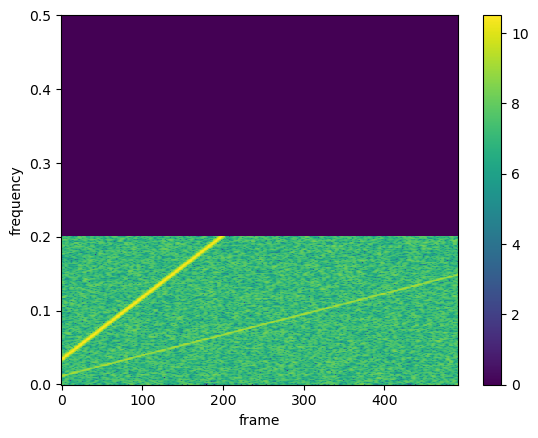

In [9]:
plot_spectrogram(Prob, db=False)

In [10]:
# Take account of harmonics 
orders = [2, 3]
for o in orders:
    Po = torch.ones_like(Prob)
    idx = torch.arange(0, spec.shape[0])[(freqs>=fmin) & (freqs<=fmax)]
    order_idx = torch.ceil(o*idx)
    Po[idx[order_idx<L]] = spec_db[order_idx[order_idx<L]]
    Prob = Prob*Po


In [11]:
# Normalize probability
epsilon = Prob.sum(dim=0, keepdim=True)
epsilon[epsilon == 0] = 1
Prob = Prob / epsilon

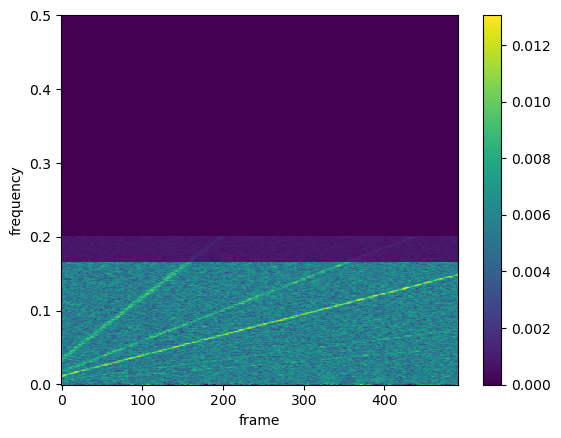

In [12]:
plot_spectrogram(Prob, db=False)

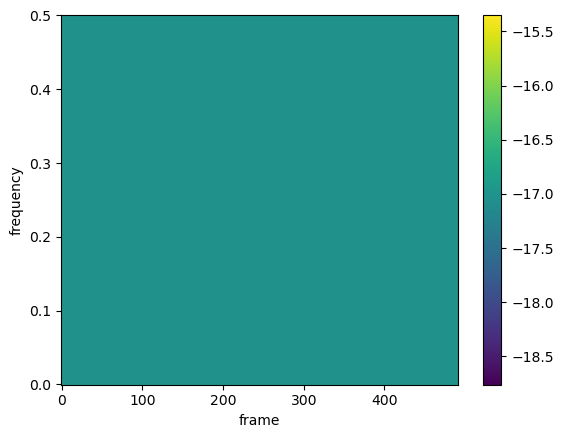

In [13]:
# Add priors fot smoothness
alpha = 100000 #en Hz/s
sigma = alpha*torch.ones(Prob.shape[1])*dt
freqs_centred = torch.arange(-L/2, L/2)*df

Prior = 0.5*(freqs_centred.repeat(T, 1).T/sigma.repeat(L, 1))**2 - torch.log(np.sqrt(2 * math.pi) * sigma.repeat(L, 1))
plot_spectrogram(Prior, db=False)

In [14]:
def dynamic_programming(Prob, Prior): 
    # Probability map
    Mmax, Tmax = Prob.shape
    cost = -torch.log(Prob)
    NbTraj = 1
    diff_max = int(Prior.shape[0]/2)

    # Cost map
    V = torch.zeros_like(Prob)
    prec = torch.zeros_like(Prob)

    # Initialization
    V[:, 0] = cost[:, 0]

    # DP loop
    for t in range(1, Tmax):
        alphat = Prior[:, t]
        for j in range(Mmax): 
            range_ = torch.arange(j - diff_max, j + diff_max + 1)
            keep = (range_ >= 0) & (range_ < Mmax)
            valid_range = range_[keep]
            penalty = alphat[keep]
            aux = V[valid_range, t - 1] + penalty
            best_i = torch.argmin(aux)
            val = aux[best_i]
            V[j, t] = val + cost[j, t]
            prec[j, t] = valid_range[best_i]

    # Best trajectories
    final_scores = V[:, -1]
    ranking = torch.argsort(final_scores)

    # Back propagation
    best = torch.argmin(final_scores)
    best_indices = torch.zeros(NbTraj, Tmax, dtype=int)
    best_indices[:, -1] = ranking[:NbTraj]
    for ii in range(NbTraj):
        for t in range(Tmax - 2, -1, -1):
            best_indices[ii, t] = prec[best_indices[ii, t + 1], t + 1]
            
    return best_indices[0]
    

In [15]:
out = dynamic_programming(Prob, Prior)

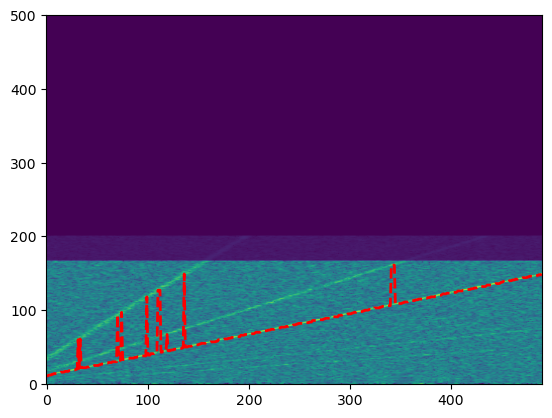

In [16]:
plt.imshow(Prob, aspect='auto', origin='lower', cmap='viridis')  # Use log for better visualization
plt.plot(out, '--r', linewidth=2); 

In [17]:
fest = torch.nn.functional.interpolate(out[None, None, ...]*df, size=y.shape[0], mode='nearest')[0, 0]

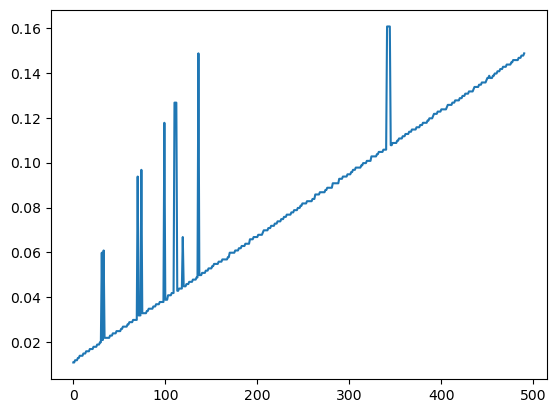

In [18]:
plt.plot(out*df)

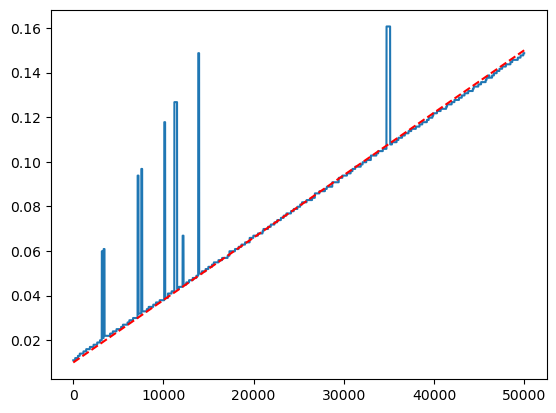

In [19]:
plt.plot(fest)
plt.plot(f, '--r')

In [20]:
def frequency_tracking(y, fs, spec, fmin, fmax, alpha): 
    # Spectrograms properties
    L = spec.shape[0]
    T = spec.shape[1]
    df = fs/2/L
    dt = y.shape[0]/(fs*T)
    
    # Compute prob
    spec_db = torch.log(spec)
    spec_db = spec_db-spec_db.min()

    freqs = torch.linspace(0, 0.5, spec.shape[0])
    # Compute probablity in [fmin, fmax]
    Prob = torch.zeros_like(spec_db)
    Prob[(freqs>=fmin) & (freqs<=fmax)] = spec_db[(freqs>=fmin) & (freqs<=fmax)]
    
    
    # Take account of harmonics 
    orders = [2, 3]
    for o in orders:
        Po = torch.ones_like(Prob)
        idx = torch.arange(0, spec.shape[0])[(freqs>=fmin) & (freqs<=fmax)]
        order_idx = torch.ceil(o*idx)
        Po[idx[order_idx<L]] = spec_db[order_idx[order_idx<L]]
        Prob = Prob*Po
        
    # Normalize probability
    epsilon = Prob.sum(dim=0, keepdim=True)
    epsilon[epsilon == 0] = 1
    Prob = Prob / epsilon
    
    # Add priors for smoothness
    sigma = alpha*torch.ones(Prob.shape[1])*dt
    freqs_centred = torch.arange(-L/2, L/2)*df

    Prior = 0.5*(freqs_centred.repeat(T, 1).T/sigma.repeat(L, 1))**2 - torch.log(np.sqrt(2 * math.pi) * sigma.repeat(L, 1))
    
    out = dynamic_programming(Prob, Prior)
    
    # Estimated frequency
    fest = torch.nn.functional.interpolate(out[None, None, ...]*df, size=y.shape[0], mode='nearest')[0, 0]
    
    return fest 
    
    

In [21]:
fest = frequency_tracking(y, fs, spec, fmin=0, fmax=0.2, alpha=1e-5)

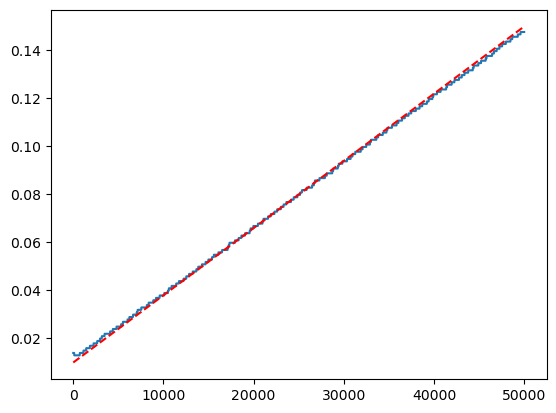

In [22]:
plt.plot(fest)
plt.plot(f, '--r')